In [1]:
import os
import pathlib

import numpy as np

import RATapi as RAT
from RATapi.models import Layer, Parameter

# Standard Layers Analysis of a DSPC Floating Bilayer

In this worksheet, we will carry out an analysis of a floating bilayer sample using a 'standard layers' model. 
The sample consists of a DSPC bilayer, on a silane SAM on Silicon:

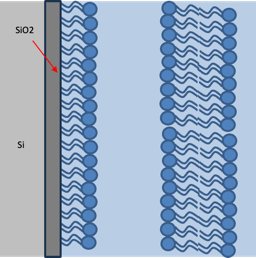

So we are going to need layers for Oxide, SAM tails, SAM heads, and the Heads/Tails of the Bilayer. We also need to consider hydration of the submerged bilayer.

## Making the Project

Start by initialising a project:

In [2]:
problem = RAT.Project(name="original_dspc_bilayer", calculation="non polarised", model="standard layers", geometry="substrate/liquid", absorption=False)

The add the parameters we are going to need:

In [3]:
parameter_list = [
    Parameter(name="Oxide Thickness", min=5.0, value=19.54, max=60.0, fit=True, prior_type="uniform"),
    Parameter(name="Oxide SLD", min=3.39e-06, value=3.39e-06, max=3.41e-06, fit=False, prior_type="uniform"),
    Parameter(name="Oxide Hydration", min=0.0, value=23.61, max=60.0, fit=True, prior_type="uniform"),
    #
    Parameter(name="SAM Tails Thickness", min=15.0, value=22.66, max=35.0, fit=True, prior_type="uniform"),
    Parameter(name="SAM Tails SLD", min=-5e-07, value=-4.01e-07, max=-3e-07, fit=False, prior_type="uniform"),
    Parameter(name="SAM Tails Hydration", min=1.0, value=5.252, max=50.0, fit=True, prior_type="uniform"),
    Parameter(name="SAM Roughness", min=1.0, value=5.64, max=15.0, fit=True, prior_type="uniform"),
    #
    Parameter(name="SAM Heads Thickness", min=5.0, value=8.56, max=17.0, fit=True, prior_type="gaussian", mu=10.0, sigma=2.0),
    Parameter(name="SAM Heads SLD", min=1.0e-07, value=1.75e-06, max=2.0e-06, fit=False, prior_type="uniform"),
    Parameter(name="SAM Heads Hydration", min=10.0, value=45.45, max=50.0, fit=True, prior_type="gaussian", mu=30.0, sigma=3.0),
    #
    Parameter(name="CW Thickness", min=10.0, value=17.12, max=28.0, fit=True, prior_type="uniform"),
    Parameter(name="CW SLD", min=0.0, value=0.0, max=1e-09, fit=False, prior_type="uniform"),
    Parameter(name="CW Hydration", min=99.9, value=100.0, max=100.0, fit=False, prior_type="uniform"),
    #
    Parameter(name="Bilayer Heads Thickness", min=7.0, value=10.7, max=17.0, fit=True, prior_type="gaussian", mu=10.0, sigma=2.0),
    Parameter(name="Bilayer Heads SLD", min=5.0e-07, value=1.47e-06, max=1.5e-06, fit=False, prior_type="uniform"),
    Parameter(name="Bilayer Heads Hydration", min=10.0, value=36.15, max=50.0, fit=True, prior_type="gaussian", mu=30.0, sigma=3.0),
    Parameter(name="Bilayer Roughness", min=2.0, value=6.014, max=15.0, fit=True, prior_type="uniform"),
    Parameter(name="Bilayer Tails Thickness", min=14.0, value=17.82, max=22.0, fit=True, prior_type="uniform"),
    Parameter(name="Bilayer Tails SLD", min=-5.0e-07, value=-4.61e-07, max=0.0, fit=False, prior_type="uniform"),
    Parameter(name="Bilayer Tails Hydration", min=10.0, value=17.64, max=50.0, fit=True, prior_type="uniform")    
]

problem.parameters.extend(parameter_list)

# In addition to these, there is also Substrate Roughness which is always parameter 1. Increase the allowed range of this a bit
problem.parameters.set_fields(0, max=10)

Now we can group these parameters into the layers we need, and add them to the project:

In [4]:
layers = [
    Layer(name="Oxide", thickness="Oxide Thickness", SLD="Oxide SLD", roughness="Substrate Roughness",
          hydration="Oxide Hydration", hydrate_with="bulk out"),
    Layer(name="SAM Tails", thickness="SAM Tails Thickness", SLD="SAM Tails SLD", roughness="SAM Roughness",
          hydration="SAM Tails Hydration", hydrate_with="bulk out"),
    Layer(name="SAM Heads", thickness="SAM Heads Thickness", SLD="SAM Heads SLD", roughness="SAM Roughness",
          hydration="SAM Heads Hydration", hydrate_with="bulk out"),
    Layer(name="Central Water", thickness="CW Thickness", SLD="CW SLD", roughness="Bilayer Roughness",
          hydration="CW Hydration", hydrate_with="bulk out"),
    Layer(name="Bilayer Heads", thickness="Bilayer Heads Thickness", SLD="Bilayer Heads SLD", roughness="Bilayer Roughness",
          hydration="Bilayer Heads Hydration", hydrate_with="bulk out"),
    Layer(name="Bilayer Tails", thickness="Bilayer Tails Thickness", SLD="Bilayer Tails SLD", roughness="Bilayer Roughness",
          hydration="Bilayer Tails Hydration", hydrate_with="bulk out")
]

problem.layers.extend(layers)

Now deal with the experimental parameters. We need a bulk in of Silicon, and two Bulk outs - D2O and SMW.

In [5]:
del problem.bulk_in[0]
problem.bulk_in.append(name="Silicon", min=2.0e-06, value=2.073e-06, max=2.1e-06, fit=False)

del problem.bulk_out[0]
problem.bulk_out.append(name="D2O", min=5.5e-06, value=5.98e-06, max=6.4e-06, fit=True)
problem.bulk_out.append(name="SMW", min=1.0e-06, value=2.21e-06, max=4.99e-06, fit=True)

Likewise the scalefactors and backgrounds:

In [6]:
del problem.scalefactors[0]
problem.scalefactors.append(name="Scalefactor 1", min=0.05, value=0.10, max=0.2, fit=False)
problem.scalefactors.append(name="Scalefactor 2", min=0.05, value=0.15, max=0.2, fit=False)

# Now deal with the backgrounds
del problem.backgrounds[0]
del problem.background_parameters[0]
problem.background_parameters.append(name="Background parameter D2O", min=5.0e-10, value=2.23e-06, max=7.0e-06, fit=True)
problem.background_parameters.append(name="Background parameter SMW", min=1.0e-10, value=3.38e-06, max=4.99e-06, fit=True)

problem.backgrounds.append(name="D2O Background", type="constant", value_1="Background parameter D2O")
problem.backgrounds.append(name="SMW Background", type="constant", value_1="Background parameter SMW")

Now load in and add the data:

In [7]:
data_path = os.path.join(pathlib.Path.cwd().parents[0].resolve(), "data")

d2o_dat = np.loadtxt(os.path.join(data_path, "DSPC_D2O.dat"), delimiter=",")
problem.data.append(name="dspc_bil_D2O", data=d2o_dat)

smw_dat = np.loadtxt(os.path.join(data_path, "DSPC_SMW.dat"), delimiter=",")
problem.data.append(name="dspc_bil_smw", data=smw_dat)

Finally, we build everything up into the two contrasts:

In [8]:
# Set the model
stack = ["Oxide", "SAM Tails", "SAM Heads", "Central Water", "Bilayer Heads", "Bilayer Tails", "Bilayer Tails", "Bilayer Heads"]

# Then make the two contrasts
problem.contrasts.append(
    name="D2O",
    bulk_in="Silicon",
    bulk_out="D2O",
    background="D2O Background",
    resolution="Resolution 1",
    scalefactor="Scalefactor 1",
    data="dspc_bil_D2O",
    model=stack,
)

problem.contrasts.append(
    name="SMW",
    bulk_in="Silicon",
    bulk_out="SMW",
    background="SMW Background",
    resolution="Resolution 1",
    scalefactor="Scalefactor 2",
    data="dspc_bil_smw",
    model=stack,
)

Print our project, to check what we have:

In [9]:
print(problem)

Name: ----------------------------------------------------------------------------------------------

original_dspc_bilayer

Calculation: ---------------------------------------------------------------------------------------

non polarised

Model: ---------------------------------------------------------------------------------------------

standard layers

Geometry: ------------------------------------------------------------------------------------------

substrate/liquid

Parameters: ----------------------------------------------------------------------------------------

+-------+-------------------------+----------+-----------+----------+-------+------------+------+-------+
| index |           name          |   min    |   value   |   max    |  fit  | prior type |  mu  | sigma |
+-------+-------------------------+----------+-----------+----------+-------+------------+------+-------+
|   0   |   Substrate Roughness   |   1.0    |    3.0    |   10.0   |  True |  uniform   | 0.0  |  

## Running the Project

To run a project in RAT, we first need to define a controls block:

In [10]:
controls = RAT.Controls(display='iter')
print(controls)

+------------------+-----------+
|     Property     |   Value   |
+------------------+-----------+
|    procedure     | calculate |
|     parallel     |   single  |
| calcSldDuringFit |   False   |
| resampleMinAngle |    0.9    |
| resampleNPoints  |     50    |
|     display      |    iter   |
+------------------+-----------+


The default action ("procedure") is just a single calculation. So call RAT.run() with this, and then plot our our initial starting position:

Starting RAT ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Elapsed time is 0.048 seconds

Finished RAT ───────────────────────────────────────────────────────────────────────────────────────────────────────────



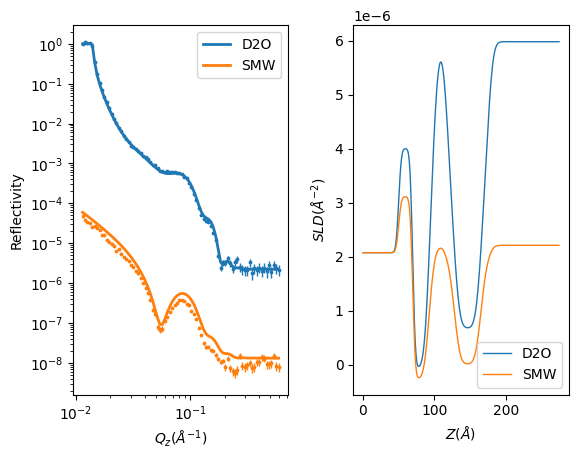

In [11]:
problem, results = RAT.run(problem, controls)
RAT.plotting.plot_ref_sld(problem, results)